In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.insert(0, 'code')

In [107]:
import os
import yaml
import pickle
from pycocotools import mask as mask_utils, coco
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchsummaryX import summary
from torchvision.models import resnet34

In [214]:
from mac import MACNetwork, ControlUnit, InputUnit, MACUnit, OutputUnit, ReadUnit, load_MAC
from utils import load_vocab
from datasets import collate_fn

In [188]:
from config import cfg_from_file, __C, cfg

cfg_from_file('cfg/local.yml')
__C.CUDA = False
__C.GPU_ID = '-1'
vocab = load_vocab(cfg)
cfg.TRAIN.RECV_OBJECTS = False

In [133]:
model = MACNetwork(cfg=cfg, max_step=1, vocab=vocab,recv_objects=False)

In [101]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [134]:
count_parameters(model)

11220374

In [29]:
count_parameters(model.obj_layers)

21294080

In [97]:
from datasets import ClevrDataset

In [488]:
ds = ClevrDataset(
    data_dir='/Users/sebamenabar/Documents/datasets/CLEVR_v1.0/data',
    img_dir='/Users/sebamenabar/Documents/datasets/CLEVR_v1.0/images/',
    scenes_json='/Users/sebamenabar/Documents/TAIA/individual/sm/data/clevr/train/scenes.json',
)

Loading data
Loading features
Loading scenes
Preparing scenes
70000/70000


In [489]:
ds[0]

(tensor([[[0.0000e+00, 3.5615e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4333e-01, 6.1406e-01, 9.6871e-02,  ..., 1.4499e-01,
           3.9514e-01, 5.3102e-01],
          [0.0000e+00, 1.3912e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.9523e-02],
          ...,
          [0.0000e+00, 2.6667e-01, 2.2526e-02,  ..., 0.0000e+00,
           0.0000e+00, 9.2792e-02],
          [0.0000e+00, 2.5094e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 3.7295e-01, 0.0000e+00,  ..., 2.5381e-01,
           0.0000e+00, 2.0073e-01]],
 
         [[1.8259e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           2.6935e-02, 2.4891e-01],
          [2.3414e-01, 2.9482e-01, 1.5071e-01,  ..., 2.3487e-01,
           4.1623e-01, 3.9568e-01],
          [4.1021e-02, 2.7687e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.2400e-02],
          ...,
          [1.8542e-02, 1.6155e-01, 7.9166e-03,  ..., 0.000

In [ ]:
ds[0]

In [486]:
mini_ds = ClevrDataset(
    data_dir='/Users/sebamenabar/Documents/TAIA/individual/sm/data/raw/CLEVR_mini/',
    img_dir='/Users/sebamenabar/Documents/TAIA/individual/sm/data/raw/CLEVR_mini/images/',
    scenes_json='/Users/sebamenabar/Documents/TAIA/individual/sm/data/raw/CLEVR_mini/CLEVR_mini_coco_anns.json',
    split='mini',
    incl_objs=True,
)

Loading data
Loading scenes
Preparing scenes
4000/4000


In [497]:
loader = DataLoader(dataset=ds, batch_size=32, shuffle=True,
                                       num_workers=2, drop_last=True, collate_fn=collate_fn)

mini_loader = DataLoader(dataset=mini_ds, batch_size=2, shuffle=True,
                                       num_workers=2, drop_last=True, collate_fn=collate_fn)

In [498]:
next(iter(loader));

In [499]:
next(iter(mini_loader))

{'question': tensor([[26,  2, 57, 54, 25, 12],
         [26,  2, 57, 43, 25, 12]]),
 'answer': tensor([2, 0]),
 'question_length': [6, 6],
 'raw_image': tensor([[[[-0.3027, -0.3027, -0.3027,  ..., -0.3541, -0.3541, -0.3541],
           [-0.3027, -0.3027, -0.3027,  ..., -0.3541, -0.3712, -0.3541],
           [-0.3198, -0.3027, -0.3027,  ..., -0.3541, -0.3712, -0.3541],
           ...,
           [-0.0629, -0.0629, -0.0629,  ...,  0.3994,  0.3823,  0.3823],
           [-0.0629, -0.0629, -0.0629,  ...,  0.3994,  0.3994,  0.3994],
           [-0.0801, -0.0629, -0.0629,  ...,  0.3994,  0.3994,  0.3994]],
 
          [[-0.1800, -0.1800, -0.1800,  ..., -0.2325, -0.2325, -0.2325],
           [-0.1800, -0.1800, -0.1800,  ..., -0.2500, -0.2500, -0.2325],
           [-0.1975, -0.1800, -0.1800,  ..., -0.2500, -0.2500, -0.2500],
           ...,
           [ 0.0476,  0.0476,  0.0476,  ...,  0.4853,  0.4853,  0.4853],
           [ 0.0476,  0.0476,  0.0476,  ...,  0.5028,  0.4853,  0.4853],
          

In [302]:
b['boxes'][:,2]

TypeError: list indices must be integers or slices, not tuple

In [314]:
print(b['boxes'][0])
print(b['boxes'][0][:,2])
print(bool((b['boxes'][0][:,3] > 0).all()))

tensor([[14, 19, 12, 19],
        [41, 18, 10, 16],
        [33, 32,  5, 10],
        [11, 12,  7, 10]])
tensor([12, 10,  5,  7])
True


In [318]:
from tqdm import tqdm

In [326]:
for scene in tqdm(ds.scenes):
    assert bool((scene['boxes'][:,2] > 0).all()) is True
    assert bool((scene['boxes'][:,3] > 0).all()) is True


100%|██████████| 70000/70000 [00:01<00:00, 39672.31it/s]

In [273]:
loader.collate_fn = collate_fn
b = next(iter(loader))

image = b['raw_image']
question = b['question']
question_len = b['question_length']
bboxes = b['boxes']

In [329]:
fpn = models.detection.backbone_utils.resnet_fpn_backbone(backbone_name='resnet101', pretrained=True)

In [330]:
fmaps = fpn(image)

In [333]:
from torchvision.ops import RoIAlign

In [342]:
roi_align = RoIAlign(output_size=(1, 1), sampling_ratio=-1, spatial_scale=1.)

In [344]:
fmaps[0].dtype

torch.float32

In [345]:
[box.to(dtype=fmaps[0].dtype) for box in bboxes]

[tensor([[ 8., 22.,  4.,  7.],
         [12., 13.,  8., 14.],
         [22.,  9.,  6., 12.],
         [32., 19.,  3.,  7.],
         [35., 10.,  7., 12.],
         [21., 23.,  3.,  7.],
         [28., 38.,  6., 11.],
         [42., 17.,  9., 17.],
         [26.,  6.,  7., 12.],
         [15., 26.,  9., 13.]]), tensor([[21., 27.,  4.,  8.],
         [11., 17.,  9., 16.],
         [17., 36.,  5.,  7.],
         [27., 17.,  3.,  7.],
         [16.,  9.,  8., 13.],
         [35., 21.,  3.,  5.],
         [44., 26.,  4.,  6.]])]

In [348]:
rois = roi_align(fmaps[0], [box.to(dtype=fmaps[0].dtype) for box in bboxes]).squeeze(-1).squeeze(-1)

In [365]:
rois.size()

torch.Size([17, 256])

In [350]:
from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence

In [351]:
[len(bbox) for bbox in bboxes]

[10, 7]

In [366]:
ts = []
j = 0
for i in [len(bbox) for bbox in bboxes]:
    ts.append(rois[j:j+i])

In [368]:
[t.size() for t in ts]

[torch.Size([10, 256]), torch.Size([7, 256])]

In [358]:
pack = PackedSequence(rois, batch_sizes=torch.tensor([len(bbox) for bbox in bboxes]), )

In [371]:
pad_sequence(ts, batch_first=True).size()

torch.Size([2, 10, 256])

In [364]:
padded[0].size()

torch.Size([10, 2, 256])

In [332]:
bboxes

[tensor([[ 8, 22,  4,  7],
         [12, 13,  8, 14],
         [22,  9,  6, 12],
         [32, 19,  3,  7],
         [35, 10,  7, 12],
         [21, 23,  3,  7],
         [28, 38,  6, 11],
         [42, 17,  9, 17],
         [26,  6,  7, 12],
         [15, 26,  9, 13]]), tensor([[21, 27,  4,  8],
         [11, 17,  9, 16],
         [17, 36,  5,  7],
         [27, 17,  3,  7],
         [16,  9,  8, 13],
         [35, 21,  3,  5],
         [44, 26,  4,  6]])]

In [264]:
cfg.TRAIN.RECV_OBJECTS = True

In [284]:
from torch.nn.utils.rnn import pad_sequence

In [298]:
model, model_ema = load_MAC(cfg, vocab)
model(b['raw_image'], b['question'], b['question_length'], b['boxes'])

torch.Size([2, 10, 512])
torch.Size([2, 10, 512])
torch.Size([2, 10, 512])
torch.Size([2, 10, 512])


tensor([[ 0.6862, -0.4228,  1.4705,  0.5821, -1.1026, -0.0798,  0.1099, -0.3893,
          0.2646,  0.5322,  0.7111,  1.0811, -0.4581,  0.1445,  1.2205, -0.6457,
          0.9858,  0.4051, -0.4800, -0.5356, -1.5637, -0.1184, -1.4390,  0.2578,
         -0.9148,  0.8735, -0.2878,  0.8386],
        [ 0.2143,  0.3589,  1.1681,  0.2219, -0.3942, -0.5360,  0.0402,  0.3952,
          1.3858, -0.0700,  0.2831,  1.0918, -0.3526, -0.3608,  0.3409, -0.3419,
          1.0338,  0.0856, -0.3301, -0.3754, -0.3807, -0.0416, -1.2290,  0.3896,
         -0.5826,  1.3156,  0.4292,  1.3221]], grad_fn=<AddmmBackward>)

In [274]:
question_embedding, contextual_words, fmaps = model.input_unit(b['raw_image'], b['question'], b['question_length'])

In [279]:
len(img_bboxes)

10

In [327]:
fmaps['56x56'].size()

torch.Size([2, 512, 56, 56])

In [287]:
objects = []
for i, img_bboxes in enumerate(bboxes):
    print(len(img_bboxes))
    img_objs = torch.stack([
        model.avg_pool(fmaps['56x56'][i, :, box[1]:box[1] +
                       box[3], box[0]:box[0] + box[2]]) for box in img_bboxes
    ])
    objects.append(img_objs.view(len(img_bboxes), 512))
    # objects.append(model.obj_linear(img_objs))

objects = pad_sequence(objects, batch_first=True)

print(objects.size())

10
7
torch.Size([2, 10, 512])


In [289]:
with open('../data/raw/CLEVR_mini/CLEVR_mini_coco_anns.json', 'r') as f:
    mini = json.load(f)

In [291]:
mini['scenes']

{'split': 'new',
 'directions': {'above': [0.0, 0.0, 1.0],
  'front': [0.754490315914154, -0.6563112735748291, -0.0],
  'left': [-0.6563112735748291, -0.7544902563095093, 0.0],
  'behind': [-0.754490315914154, 0.6563112735748291, 0.0],
  'right': [0.6563112735748291, 0.7544902563095093, -0.0],
  'below': [-0.0, -0.0, -1.0]},
 'image_index': 0,
 'relationships': {'behind': [[1, 5, 7, 9],
   [],
   [0, 1, 5, 6, 7, 9],
   [0, 1, 2, 4, 5, 6, 7, 8, 9],
   [0, 1, 2, 5, 6, 7, 8, 9],
   [1, 7],
   [0, 1, 5, 7, 9],
   [1],
   [0, 1, 2, 5, 6, 7, 9],
   [1, 5, 7]],
  'front': [[2, 3, 4, 6, 8],
   [0, 2, 3, 4, 5, 6, 7, 8, 9],
   [3, 4, 8],
   [],
   [3],
   [0, 2, 3, 4, 6, 8, 9],
   [2, 3, 4, 8],
   [0, 2, 3, 4, 5, 6, 8, 9],
   [3, 4],
   [0, 2, 3, 4, 6, 8]],
  'right': [[5, 6, 8],
   [0, 3, 5, 6, 7, 8],
   [0, 1, 3, 4, 5, 6, 7, 8],
   [0, 5, 6, 7, 8],
   [0, 1, 3, 5, 6, 7, 8],
   [6],
   [],
   [0, 5, 6, 8],
   [5, 6],
   [0, 1, 2, 3, 4, 5, 6, 7, 8]],
  'left': [[1, 2, 3, 4, 7, 9],
   [2, 4, 9],


In [ ]:
mini_scenes = []
for scene in mini['scenes']:
    mini_scenes.append({
        'split'
    })

In [293]:
import pandas as pd

In [294]:
df = pd.DataFrame(mini['scenes'])

In [373]:
df['scene_size'] = df.objects.apply(lambda o: len(o))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x27da7e588>]],
      dtype=object)

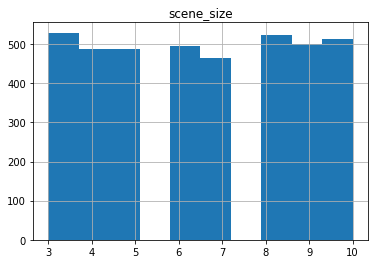

In [375]:
df.hist(column='scene_size')

In [376]:
small_scenes = df[df.scene_size <= 4]

In [381]:
small_scenes.iloc[0].objects

[{'pixel_coords': [214, 124, 11.449300765991211],
  'color': 'purple',
  'size': 'large',
  'shape': 'cylinder',
  'rotation': 4.896119520629716,
  '3d_coords': [-0.6542897820472717, -0.17562657594680786, 0.699999988079071],
  'material': 'rubber',
  'mask': {'size': [320, 480],
   'counts': 'nZh17g9f0[Od0\\O`0A2M2O1N2O1N101O0O2O00001N10001O00000O10001O000000000000000000000000000000000000O1000001O000O10000O2O000O101N101N101N1O2N2N2MVQY2'}},
 {'pixel_coords': [140, 182, 9.738595008850098],
  'color': 'yellow',
  'size': 'small',
  'shape': 'cylinder',
  'rotation': 2.4736503380328148,
  '3d_coords': [0.01616791822016239, -2.516709566116333, 0.3499999940395355],
  'material': 'rubber',
  'mask': {'size': [320, 480],
   'counts': 'U[U1<c9:F:F8H2O1N2O1O0O101O0O10001O0000000O1000000000O2O0000000O101O0O101N101N2N5K?A>AQjS3'}},
 {'pixel_coords': [414, 149, 10.229849815368652],
  'color': 'purple',
  'size': 'large',
  'shape': 'cylinder',
  'rotation': 1.7990498333215177,
  '3d_coords': [2.99

In [378]:
small_scenes

,directions,image_filename,image_index,objects,relationships,split,scene_size
11,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000011.png,11,"[{'pixel_coords': [214, 124, 11.44930076599121...","{'behind': [[], [0, 2], [0]], 'front': [[1, 2]...",new,3
17,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000017.png,17,"[{'pixel_coords': [215, 139, 11.49367332458496...","{'behind': [[], [0, 2], [0]], 'front': [[1, 2]...",new,3
20,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000020.png,20,"[{'pixel_coords': [140, 138, 11.42140483856201...","{'behind': [[3], [0, 3], [0, 1, 3], []], 'fron...",new,4
37,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000037.png,37,"[{'pixel_coords': [356, 140, 11.32317352294921...","{'behind': [[], [0, 2, 3], [0, 3], [0]], 'fron...",new,4
39,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000039.png,39,"[{'pixel_coords': [194, 201, 9.679601669311523...","{'behind': [[1, 2], [], [1]], 'front': [[], [0...",new,3
73,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000073.png,73,"[{'pixel_coords': [184, 153, 11.12311649322509...","{'behind': [[2], [0, 2], []], 'front': [[1], [...",new,3
75,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000075.png,75,"[{'pixel_coords': [121, 153, 10.50188732147216...","{'behind': [[2, 3], [0, 2, 3], [3], []], 'fron...",new,4
78,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000078.png,78,"[{'pixel_coords': [250, 169, 9.344255447387695...","{'behind': [[1, 2], [], [1]], 'front': [[], [0...",new,3
89,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000089.png,89,"[{'pixel_coords': [204, 161, 10.94448661804199...","{'behind': [[2, 3], [0, 2, 3], [], [2]], 'fron...",new,4
91,"{'above': [0.0, 0.0, 1.0], 'front': [0.7544903...",CLEVR_mini_000091.png,91,"[{'pixel_coords': [249, 69, 14.108052253723145...","{'behind': [[], [0, 2], [0]], 'front': [[1, 2]...",new,3


In [393]:
sizes = np.array(['large', 'small'])
colors = np.array(['gray', 'red', 'blue', 'green', 'brown', 'purple', 'cyan', 'yellow'])
shapes = np.array(['cube', 'sphere', 'cylinder'])
materials = np.array(['rubber', 'metal'])

attributes = dict(sizes=sizes, colors=colors, shapes=shapes, materials=materials)

In [406]:
from tqdm import tqdm_notebook as tqdm

In [467]:
questions = {}

for idx, scene in tqdm(small_scenes.iterrows(), total=len(small_scenes)):
    
    image_filename = scene['image_filename']
    questions[image_filename] = []
    
    scene_objects = scene.objects
    
    scene_sizes = [obj['size'] for obj in scene_objects]
    scene_colors = [obj['color'] for obj in scene_objects]
    scene_shapes = [obj['shape'] for obj in scene_objects]
    scene_materials = [obj['material'] for obj in scene_objects]
    
    scene_attributes = dict(sizes=scene_sizes, colors=scene_colors, shapes=scene_shapes, materials=scene_materials)

    for attribute, values in attributes.items():
        not_in = values[~np.isin(values, scene_attributes[attribute])]
        
        if len(not_in):
            chosen_negatives = np.random.choice(not_in, replace=False, size=min(2, len(not_in)))
            for chosen in chosen_negatives:
                if attribute == 'shapes':
                    questions[image_filename].append((f'Is there a {chosen} ?', 'no'))
                else:
                    questions[image_filename].append((f'Is there a {chosen} object ?', 'no'))

        uniques, indexes, counts = np.unique(scene_attributes[attribute], return_counts=True, return_index=True)
        for unique, index, count in zip(uniques, indexes, counts):
            if count == 1:
                if attribute == 'shapes':
                    questions[image_filename].append((f'Is there a {unique} ?', 'yes', (attribute.rstrip('s'), unique, index)))
                else:
                    questions[image_filename].append((f'Is there a {unique} object ?', 'yes', (attribute.rstrip('s'), unique, index)))

In [456]:
uniques, index, counts = np.unique(scene_attributes[attribute], return_counts=True, return_index=True)

In [458]:
print(scene_attributes[attribute])
uniques, index, counts

['metal', 'rubber', 'rubber']


(array(['metal', 'rubber'], dtype='<U6'), array([0, 1]), array([1, 2]))

In [463]:
questions

{'CLEVR_mini_000011.png': [('Is there a small object ?',
   'yes',
   ('size', 'small', 1)),
  ('Is there a brown object ?', 'no'),
  ('Is there a gray object ?', 'no'),
  ('Is there a yellow object ?', 'yes', ('color', 'yellow', 1)),
  ('Is there a cube ?', 'no'),
  ('Is there a sphere ?', 'no'),
  ('Is there a metal object ?', 'yes', ('material', 'metal', 2))],
 'CLEVR_mini_000017.png': [('Is there a large object ?',
   'yes',
   ('size', 'large', 1)),
  ('Is there a cyan object ?', 'no'),
  ('Is there a yellow object ?', 'no'),
  ('Is there a green object ?', 'yes', ('color', 'green', 2)),
  ('Is there a purple object ?', 'yes', ('color', 'purple', 1)),
  ('Is there a red object ?', 'yes', ('color', 'red', 0)),
  ('Is there a cube ?', 'no'),
  ('Is there a sphere ?', 'yes', ('shape', 'sphere', 1)),
  ('Is there a rubber object ?', 'yes', ('material', 'rubber', 2))],
 'CLEVR_mini_000020.png': [('Is there a large object ?',
   'yes',
   ('size', 'large', 2)),
  ('Is there a purple obj

In [440]:
len(questions)

1017

In [441]:
sum((len(q) for q in questions))

21357

In [420]:
word2token_q  = pd.Series(vocab['question_token_to_idx'])
word2token_a  = pd.Series(vocab['answer_token_to_idx'])

In [419]:
word2token_q

Are           1
there         2
more          3
big           4
green         5
things        6
than          7
large         8
purple        9
shiny        10
cubes        11
?            12
How          13
many         14
other        15
are          16
of           17
the          18
same         19
shape        20
as           21
tiny         22
cyan         23
matte        24
object       25
Is           26
color        27
sphere       28
cube         29
What         30
             ..
its          61
in           62
front        63
does         64
number       65
red          66
spheres      67
made         68
metal        69
cylinders    70
both         71
how          72
balls        73
or           74
blocks       75
objects      76
visible      77
Does         78
another      79
has          80
greater      81
fewer        82
less         83
either       84
anything     85
else         86
Do           87
an           88
equal        89
pad           0
Length: 90, dtype: int64

In [443]:
questions

{'CLEVR_mini_000011.png': [('Is there a small object ?',
   'yes',
   ('size', 'small')),
  ('Is there a green object ?', 'no'),
  ('Is there a brown object ?', 'no'),
  ('Is there a yellow object ?', 'yes', ('color', 'yellow')),
  ('Is there a cube ?', 'no'),
  ('Is there a sphere ?', 'no'),
  ('Is there a metal object ?', 'yes', ('material', 'metal'))],
 'CLEVR_mini_000017.png': [('Is there a large object ?',
   'yes',
   ('size', 'large')),
  ('Is there a brown object ?', 'no'),
  ('Is there a cyan object ?', 'no'),
  ('Is there a green object ?', 'yes', ('color', 'green')),
  ('Is there a purple object ?', 'yes', ('color', 'purple')),
  ('Is there a red object ?', 'yes', ('color', 'red')),
  ('Is there a cube ?', 'no'),
  ('Is there a sphere ?', 'yes', ('shape', 'sphere')),
  ('Is there a rubber object ?', 'yes', ('material', 'rubber'))],
 'CLEVR_mini_000020.png': [('Is there a large object ?',
   'yes',
   ('size', 'large')),
  ('Is there a red object ?', 'no'),
  ('Is there a yel

In [469]:
questions_std = []

for image_filename, img_questions in tqdm(questions.items()):
    for question in img_questions:
        if len(question) == 2:
            questions_std.append((image_filename, word2token_q.loc[question[0].split()].values.tolist(), word2token_a.loc[question[1]]))
        else:
            questions_std.append((image_filename, word2token_q.loc[question[0].split()].values.tolist(), word2token_a.loc[question[1]], question[2]))º

In [470]:
questions_std

[('CLEVR_mini_000011.png', [26, 2, 57, 42, 25, 12], 0, ('size', 'small', 1)),
 ('CLEVR_mini_000011.png', [26, 2, 57, 35, 25, 12], 2),
 ('CLEVR_mini_000011.png', [26, 2, 57, 23, 25, 12], 2),
 ('CLEVR_mini_000011.png', [26, 2, 57, 55, 25, 12], 0, ('color', 'yellow', 1)),
 ('CLEVR_mini_000011.png', [26, 2, 57, 29, 12], 2),
 ('CLEVR_mini_000011.png', [26, 2, 57, 28, 12], 2),
 ('CLEVR_mini_000011.png',
  [26, 2, 57, 69, 25, 12],
  0,
  ('material', 'metal', 2)),
 ('CLEVR_mini_000017.png', [26, 2, 57, 8, 25, 12], 0, ('size', 'large', 1)),
 ('CLEVR_mini_000017.png', [26, 2, 57, 55, 25, 12], 2),
 ('CLEVR_mini_000017.png', [26, 2, 57, 35, 25, 12], 2),
 ('CLEVR_mini_000017.png', [26, 2, 57, 5, 25, 12], 0, ('color', 'green', 2)),
 ('CLEVR_mini_000017.png', [26, 2, 57, 9, 25, 12], 0, ('color', 'purple', 1)),
 ('CLEVR_mini_000017.png', [26, 2, 57, 66, 25, 12], 0, ('color', 'red', 0)),
 ('CLEVR_mini_000017.png', [26, 2, 57, 29, 12], 2),
 ('CLEVR_mini_000017.png', [26, 2, 57, 28, 12], 0, ('shape', 's

In [438]:
np.unique([q[2] for q in  questions_std], return_counts=True)

(array([0, 2]), array([5074, 3193]))

In [472]:
questions

{'CLEVR_mini_000011.png': [('Is there a small object ?',
   'yes',
   ('size', 'small', 1)),
  ('Is there a brown object ?', 'no'),
  ('Is there a cyan object ?', 'no'),
  ('Is there a yellow object ?', 'yes', ('color', 'yellow', 1)),
  ('Is there a cube ?', 'no'),
  ('Is there a sphere ?', 'no'),
  ('Is there a metal object ?', 'yes', ('material', 'metal', 2))],
 'CLEVR_mini_000017.png': [('Is there a large object ?',
   'yes',
   ('size', 'large', 1)),
  ('Is there a yellow object ?', 'no'),
  ('Is there a brown object ?', 'no'),
  ('Is there a green object ?', 'yes', ('color', 'green', 2)),
  ('Is there a purple object ?', 'yes', ('color', 'purple', 1)),
  ('Is there a red object ?', 'yes', ('color', 'red', 0)),
  ('Is there a cube ?', 'no'),
  ('Is there a sphere ?', 'yes', ('shape', 'sphere', 1)),
  ('Is there a rubber object ?', 'yes', ('material', 'rubber', 2))],
 'CLEVR_mini_000020.png': [('Is there a large object ?',
   'yes',
   ('size', 'large', 2)),
  ('Is there a green obj

In [471]:
with open('../data/raw/CLEVR_mini/curriculum_questions.json', 'w') as f:
    json.dump(questions, f)

TypeError: Object of type int64 is not JSON serializable

In [480]:
with open('../data/raw/CLEVR_mini/mini.pkl', 'wb') as f:
    pickle.dump(questions_std, f)

In [392]:
sizes_not_in, scene_sizes

(array([], dtype='<U5'), ['large', 'small', 'large'])

In [387]:
vocab

{'question_token_to_idx': {'Are': 1,
  'there': 2,
  'more': 3,
  'big': 4,
  'green': 5,
  'things': 6,
  'than': 7,
  'large': 8,
  'purple': 9,
  'shiny': 10,
  'cubes': 11,
  '?': 12,
  'How': 13,
  'many': 14,
  'other': 15,
  'are': 16,
  'of': 17,
  'the': 18,
  'same': 19,
  'shape': 20,
  'as': 21,
  'tiny': 22,
  'cyan': 23,
  'matte': 24,
  'object': 25,
  'Is': 26,
  'color': 27,
  'sphere': 28,
  'cube': 29,
  'What': 30,
  'material': 31,
  'is': 32,
  'that': 33,
  'right': 34,
  'brown': 35,
  'cylinder': 36,
  'and': 37,
  'left': 38,
  'gray': 39,
  'on': 40,
  'side': 41,
  'small': 42,
  'rubber': 43,
  'behind': 44,
  'thing': 45,
  'to': 46,
  'metallic': 47,
  'The': 48,
  'what': 49,
  'size': 50,
  'any': 51,
  'have': 52,
  'block': 53,
  'blue': 54,
  'yellow': 55,
  'There': 56,
  'a': 57,
  ';': 58,
  'it': 59,
  'ball': 60,
  'its': 61,
  'in': 62,
  'front': 63,
  'does': 64,
  'number': 65,
  'red': 66,
  'spheres': 67,
  'made': 68,
  'metal': 69,
  'cy

In [218]:
b['boxes'][0]

tensor([[23,  9,  6,  9],
        [13, 11,  7, 13],
        [45, 15, 10, 16],
        [36, 19,  4,  7]])

In [224]:
fmaps[0].size()

torch.Size([1, 256, 56, 56])

In [229]:
fmaps[0][0].size()

torch.Size([1, 256, 56, 56])

In [231]:
for box in b['boxes'][0]:
    print(fmaps[0][0,:, box[1]:box[1]+box[3], box[0]:box[0]+box[2]].size())

torch.Size([256, 9, 6])
torch.Size([256, 13, 7])
torch.Size([256, 16, 10])
torch.Size([256, 7, 4])


In [197]:
[m.size() for m in fmaps.values()]

[torch.Size([1, 256, 56, 56]),
 torch.Size([1, 256, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 256, 7, 7]),
 torch.Size([1, 256, 4, 4])]

In [237]:
fmaps[0][0,:, box[1]:box[1]+box[3], box[0]:box[0]+box[2]].size()

torch.Size([256, 7, 4])

In [251]:
nn.AdaptiveAvgPool2d((7, 7))(fmaps[0][0,:, box[1]:box[1]+box[3], box[0]:box[0]+box[2]]).size()

torch.Size([256, 7, 7])

In [261]:
count_parameters(nn.Linear(256 * 1 * 1, 512))

131584

In [256]:
fpn_50 = models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)

In [9]:
with open('data/dic.pkl', 'rb') as f:
    dic = pickle.load(f)
    word_dic, answer_dic = dic['word_dic'], dic['answer_dic']

In [10]:
def read_image(filename, split='train'):
    return Image.open(os.path.join(f'../data/clevr/{split}/images/', filename)).convert('RGB')

In [13]:
model = MACNetwork(cfg=__C, max_step=2, vocab=vocab)

In [14]:
import json

In [15]:
with open('../data/clevr_sample_mod/train/scenes.json', 'r') as f:
    train_scenes = json.load(f)

In [16]:
scene_3 = train_scenes['3']

In [17]:
image = read_image(scene_3['image_filename'])

In [18]:
boxes = np.array([mask_utils.toBbox(m['mask']) for m in scene_3['objects_detection']])

In [19]:
areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

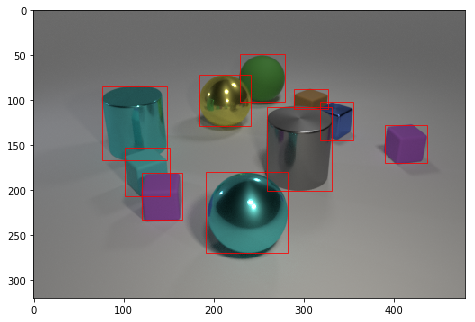

In [20]:
img = np.array(image)
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(img)

box_alpha = 1
for bbox in boxes:
    ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2],
                              bbox[3],
                              fill=False, edgecolor='r',
    linewidth=0.8, alpha=box_alpha))

In [21]:
import torch
from torchvision import transforms

In [22]:
_transform = transforms.Compose([
    transforms.Resize((149, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [23]:
img = _transform(image)

In [24]:
def norm_bbox(bbox, initial_size, final_size):
    bbox = bbox.copy()
    bbox[:, 0] = (bbox[:, 0] / initial_size[1]) * final_size[1]
    bbox[:, 1] = (bbox[:, 1] / initial_size[0]) * final_size[0]
    bbox[:, 2] = (bbox[:, 2] / initial_size[1]) * final_size[1]
    bbox[:, 3] = (bbox[:, 3] / initial_size[0]) * final_size[0]
    
    return bbox.astype(np.int)

In [25]:
_norm_boxes = norm_bbox(boxes, (320, 480), (149, 224))

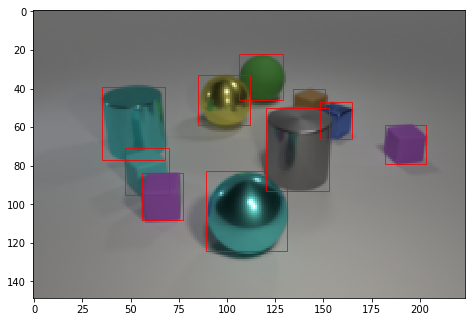

In [26]:
img = np.array(transforms.Resize((149, 224))(image))
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(img)

box_alpha = 1
for bbox in _norm_boxes:
    ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2],
                              bbox[3],
                              fill=False, edgecolor='r',
    linewidth=0.8, alpha=box_alpha))

In [27]:
_transform = transforms.Compose([
    transforms.Resize((149, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def concat_obj_img(scene, split='train'):
    img = read_image(scene['image_filename'], split=split)
    img = _transform(img)
    boxes = norm_bbox(
        np.array([mask_utils.toBbox(m['mask']) for m in scene['objects_detection']]),
        (320, 480), (149, 224),
    )

    fig, ax = plt.subplots(1,1, frameon=False)
    ax.imshow(img.numpy().transpose(1, 2, 0))

    print(boxes)
    
    box_alpha = 1
    for bbox in boxes:
        ax.add_patch(
                    plt.Rectangle((bbox[0], bbox[1]),
                                  bbox[2],
                                  bbox[3],
                                  fill=False, edgecolor='r',
        linewidth=0.8, alpha=box_alpha))

    img = img.unsqueeze(0).repeat(len(boxes), 2, 1, 1)
    
        
    

[[148  47  17  19]
 [134  40  17  10]
 [ 47  71  23  24]
 [ 35  39  33  38]
 [ 89  83  42  41]
 [120  50  33  43]
 [106  22  23  24]
 [ 56  84  21  24]
 [182  59  21  20]
 [ 85  33  27  26]]


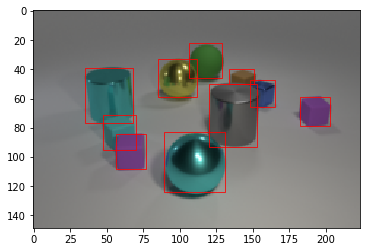

In [28]:
concat_obj_img(scene_3)

In [29]:
img = read_image(scene_3['image_filename'], split='train')
img = _transform(img)

In [30]:
boxes = norm_bbox(
        np.array([mask_utils.toBbox(m['mask']) for m in scene_3['objects_detection']]),
        (320, 480), (149, 224),
    )

In [31]:
boxes

array([[148,  47,  17,  19],
       [134,  40,  17,  10],
       [ 47,  71,  23,  24],
       [ 35,  39,  33,  38],
       [ 89,  83,  42,  41],
       [120,  50,  33,  43],
       [106,  22,  23,  24],
       [ 56,  84,  21,  24],
       [182,  59,  21,  20],
       [ 85,  33,  27,  26]])

In [32]:
exp = img.unsqueeze(0).repeat(len(boxes), 2, 1, 1)
exp.size()

torch.Size([10, 6, 149, 224])

In [33]:
exp[:, 3:, :, :] = 0

In [34]:
for i, box in enumerate(boxes):
    print(exp[i, 3:, box[1]:box[1]+box[3], box[0]:box[0]+box[2]])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [35]:
for i, box in enumerate(boxes):
    exp[i, 3:, box[1]:box[1]+box[3], box[0]:box[0]+box[2]] = exp[i, :3, box[1]:box[1]+box[3], box[0]:box[0]+box[2]]

In [36]:
for i, box in enumerate(boxes):
    print(exp[i, 3:, box[1]:box[1]+box[3], box[0]:box[0]+box[2]])

tensor([[[0.3216, 0.3255, 0.3255, 0.3294, 0.4000, 0.4980, 0.4549, 0.4471,
          0.4824, 0.5059, 0.5098, 0.5137, 0.5098, 0.5059, 0.5059, 0.5059,
          0.5059],
         [0.3216, 0.3255, 0.3255, 0.3255, 0.3490, 0.3255, 0.2275, 0.2157,
          0.2706, 0.3451, 0.4235, 0.4784, 0.5020, 0.5137, 0.5137, 0.5098,
          0.5098],
         [0.3216, 0.3216, 0.2980, 0.2314, 0.1765, 0.1569, 0.1529, 0.1608,
          0.1765, 0.1882, 0.2000, 0.2392, 0.3059, 0.3843, 0.4549, 0.4980,
          0.5098],
         [0.3020, 0.2392, 0.1725, 0.1451, 0.1412, 0.1451, 0.1412, 0.1490,
          0.1647, 0.1725, 0.1569, 0.1529, 0.1490, 0.1608, 0.1961, 0.2549,
          0.3451],
         [0.2667, 0.1961, 0.1608, 0.1490, 0.1529, 0.1529, 0.1569, 0.1686,
          0.1804, 0.1647, 0.1490, 0.1412, 0.1412, 0.1412, 0.1333, 0.1176,
          0.0941],
         [0.3216, 0.3059, 0.2588, 0.1922, 0.1529, 0.1608, 0.1804, 0.1922,
          0.1922, 0.1804, 0.1608, 0.1490, 0.1373, 0.1176, 0.0863, 0.0784,
          0.1255]

In [37]:
exp.size()

torch.Size([10, 6, 149, 224])

In [25]:
from torch import nn
from torchvision.models import resnet34

In [26]:
resnet = resnet34(pretrained=True)

In [109]:
from torchsummaryX import summary

In [120]:
exp.unsqueeze(0).expand(2, 10, 6, 149, 224).size()[-3:]

torch.Size([6, 149, 224])

In [122]:
expanded = exp.unsqueeze(0).expand(2, 10, 6, 149, 224)
expanded.size()

torch.Size([2, 10, 6, 149, 224])

In [126]:
res = main(expanded.contiguous().view(-1, *expanded.size()[-3:]))

In [129]:
res.view(2, 10, -1).size()

torch.Size([2, 10, 512])